# Exploratory Data Analysis for Ultimate Login Activities 

![login](images/login.png)

The logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Report/illustrate important features of the demand, such as daily cycles.

# Import packages and define functions

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle 

import shap

#import plotly

%matplotlib inline 

sns.set_style('ticks', rc={'xtick.direction':'in', 'ytick.direction':'in', \
                           'xtick.top':True, 'ytick.right':True})

# Load Datasets

In [2]:
datadir    = '../datasets/raw'
datadir_pr = '../datasets/processed'  # directory where the cleaned datasets are stored
figdir     = '../output/figures'

## Data load and wrangling

In [3]:
''' read the dataset '''

df_log = pd.read_json(os.path.join(datadir, 'logins.json'))

In [4]:
df_log.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [5]:
df_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [6]:
df_log.isnull().sum()

login_time    0
dtype: int64

> There is no null data!

In [7]:
''' add column: counts '''
df_log['Counts'] = 1

In [8]:
''' set index '''

df_log.set_index('login_time', inplace=True)
df_log.head()

,Counts
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [9]:
''' aggregate the login counts based on 15minutes time intervals '''

df_log15 = df_log.resample('15T').sum()
df_log15.head()

,Counts
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [10]:
df_log15.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15T
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Counts  9788 non-null   int64
dtypes: int64(1)
memory usage: 152.9 KB


> No null values!

In [11]:
df_log15['Month'] = df_log15.index.month
df_log15['Day'] = df_log15.index.day
df_log15['Week_year'] = df_log15.index.isocalendar().week
df_log15['Weekday'] = df_log15.index.weekday
df_log15['Weekend'] = ((df_log15.index.weekday) // 5 == 1).astype(int)
df_log15['Hour'] = df_log15.index.hour

In [12]:
df_log15

,Counts,Month,Day,Week_year,Weekday,Weekend,Hour
login_time,,,,,,,
1970-01-01 20:00:00,2,1,1,1,3,0,20
1970-01-01 20:15:00,6,1,1,1,3,0,20
1970-01-01 20:30:00,9,1,1,1,3,0,20
1970-01-01 20:45:00,7,1,1,1,3,0,20
1970-01-01 21:00:00,1,1,1,1,3,0,21
...,...,...,...,...,...,...,...
1970-04-13 17:45:00,5,4,13,16,0,0,17
1970-04-13 18:00:00,5,4,13,16,0,0,18
1970-04-13 18:15:00,2,4,13,16,0,0,18


## Login activities by periods

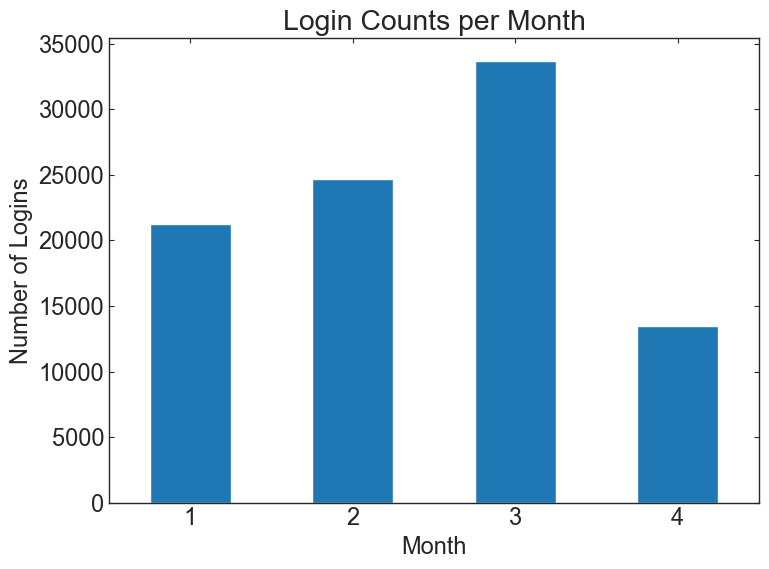

In [13]:
''' login activities by months '''

fig, ax = plt.subplots()
df_log15.groupby('Month').Counts.sum().plot(kind='bar', ax=ax)

ax.tick_params(axis='x', rotation=0)
ax.set(title='Login Counts per Month', ylabel='Number of Logins')

fig.tight_layout()
fig.savefig(os.path.join(figdir,'count_month.png'));

> Login is the most active in March, showing the monotonous increase from January. Login activity drops to 13k, but it is because it contains the data only for 13 days.

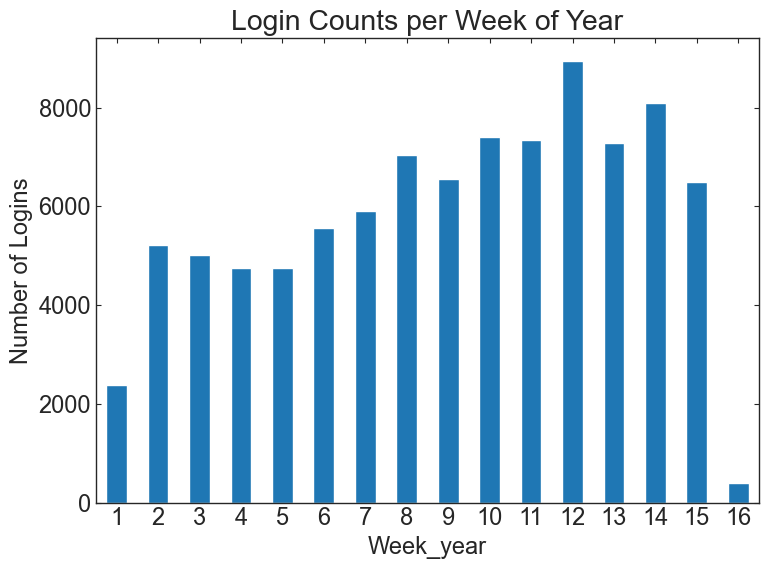

In [14]:
''' login activities by week of year '''

fig, ax = plt.subplots()
df_log15.groupby('Week_year').Counts.sum().plot(kind='bar', ax=ax)

ax.tick_params(axis='x', rotation=0)
ax.set(title='Login Counts per Week of Year', ylabel='Number of Logins')

fig.tight_layout()
fig.savefig(os.path.join(figdir,'count_weekofyear.png'));

> Logins are the most active in 12th week, which is the last week of March. Overall, login activities are increasing to 8th week, after which it shows plateau. 

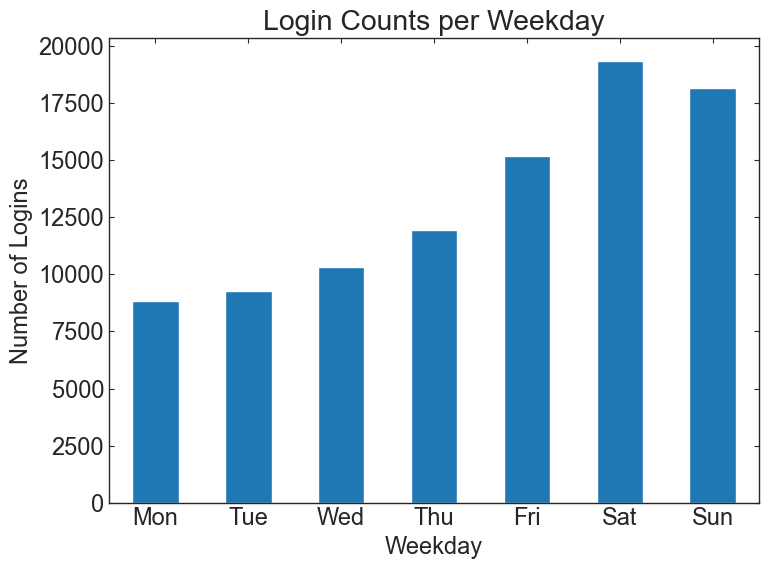

In [15]:
''' login activities by weekdays '''

# xtick format function 
week_name = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
#ticklabel_func = lambda value, tick_number: week_name[value]

fig, ax = plt.subplots()
df_log15.groupby('Weekday').Counts.sum().plot(kind='bar', ax=ax)
ax.tick_params(axis='x', rotation=0)

#ax.xaxis.set_major_formatter(plt.FuncFormatter(ticklabel_func))
ax.set_xticklabels([week_name[d] for d in range(len(week_name))])
ax.set(title='Login Counts per Weekday', ylabel='Number of Logins')

fig.tight_layout()
fig.savefig(os.path.join(figdir,'count_week.png'));

> Login activities keep increasing from Monday to Saturday. 

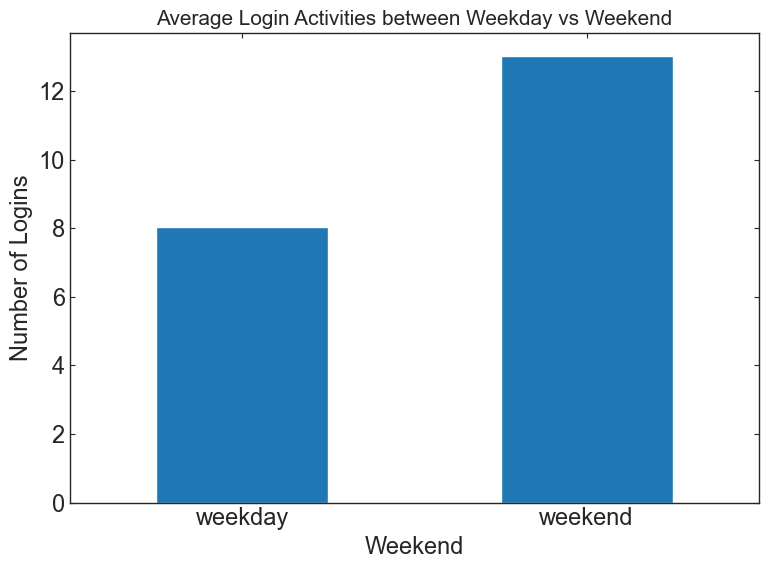

In [16]:
''' average login activities between weekday vs. weekend '''

# xtick format function 
weekend_name = {0:'weekday', 1:'weekend'}

fig, ax = plt.subplots()
df_log15.groupby('Weekend').Counts.mean().plot(kind='bar', ax=ax)
ax.tick_params(axis='x', rotation=0)

ax.set_xticklabels([weekend_name[d] for d in range(len(weekend_name))])
ax.set_title('Average Login Activities between Weekday vs Weekend', fontsize=15) 
ax.set_ylabel('Number of Logins')

fig.tight_layout()
fig.savefig(os.path.join(figdir,'count_weekend.png'));

> Logins are more active in weekend than in weekdays.

In [17]:
# resample to the frequency of day
df_logD = df_log.resample('D').sum()
df_logD['Weekday'] = df_logD.index.weekday

df_logD.head()

,Counts,Weekday
login_time,,
1970-01-01,112,3
1970-01-02,681,4
1970-01-03,793,5
1970-01-04,788,6
1970-01-05,459,0


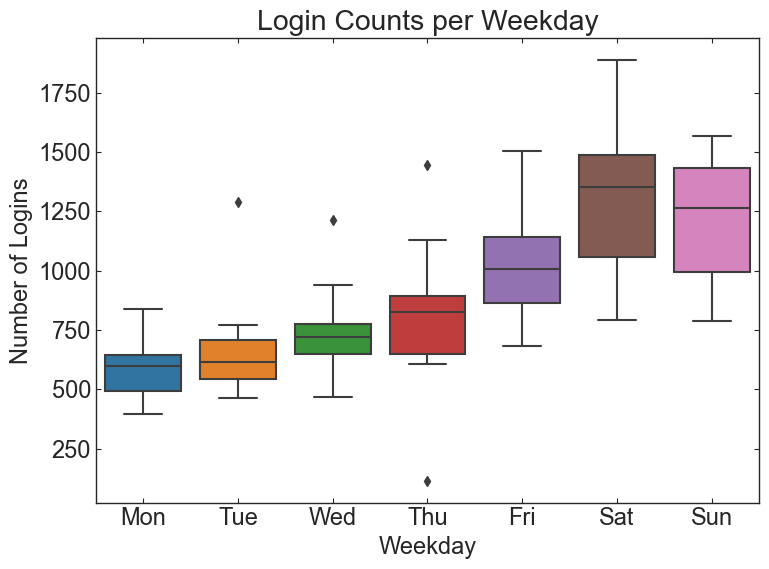

In [19]:
fig, ax = plt.subplots()

week_name = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}

sns.boxplot(x='Weekday', y='Counts', data=df_logD, ax=ax)

ax.set_xticklabels([week_name[d] for d in range(7)])
ax.set(title='Login Counts per Weekday', ylabel='Number of Logins')

fig.tight_layout()
fig.savefig(os.path.join(figdir,'box_week.png'));

> Similarly, the total number of logins is increasing from Monday to Saturday. One notable thing is that there are outliers on Tuesday, Wednesday, and Thursday, and the variation is the most on Saturday. 

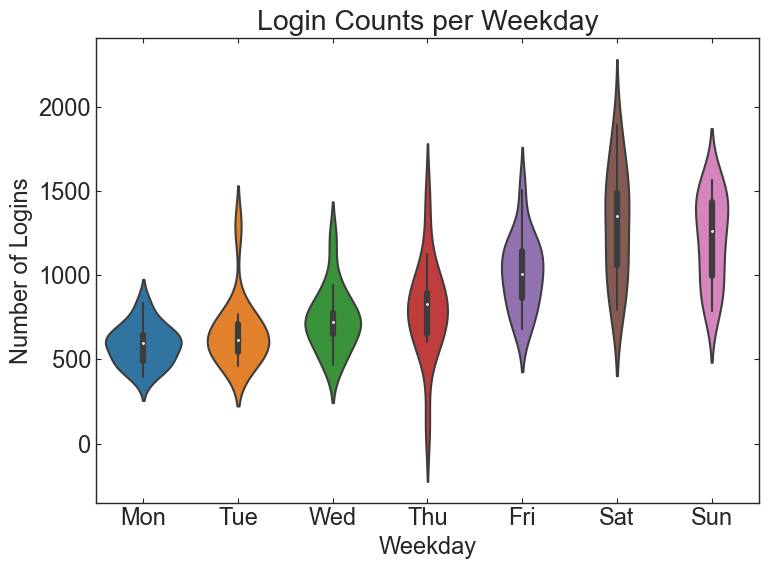

In [20]:
fig, ax = plt.subplots()

week_name = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}

sns.violinplot(x='Weekday', y='Counts', data=df_logD, ax=ax)

ax.set_xticklabels([week_name[d] for d in range(7)])
ax.set(title='Login Counts per Weekday', ylabel='Number of Logins')

fig.tight_layout()
fig.savefig(os.path.join(figdir,'violin_week.png'));

### Login activities in daily cycle

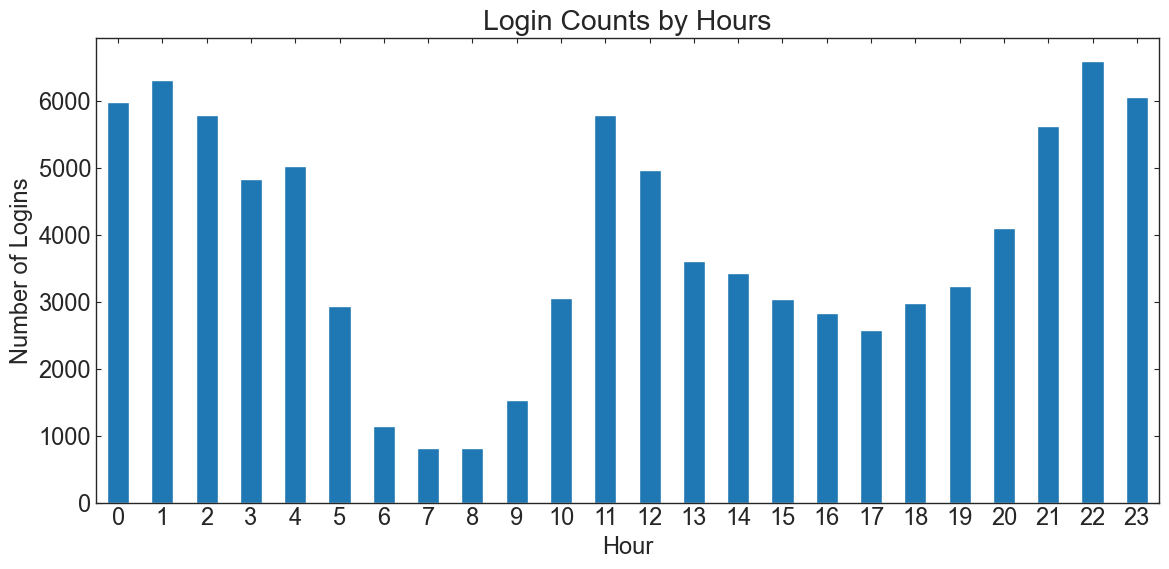

In [21]:
''' login activities by week of year '''

fig, ax = plt.subplots(figsize=(12,6))
df_log15.groupby('Hour').Counts.sum().plot(kind='bar', ax=ax)

ax.tick_params(axis='x', rotation=0)
ax.set(title='Login Counts by Hours', ylabel='Number of Logins')

fig.tight_layout()
fig.savefig(os.path.join(figdir,'count_hour.png'));

> Logins are the least active in the morning, and there are the highest logins at 11am - noon and 9pm - 1am. 

In [22]:
# resample to the frequency of 1 hour
df_logH = df_log.resample('H').sum()
df_logH['Hour'] = df_logH.index.hour

df_logH.head()

,Counts,Hour
login_time,,
1970-01-01 20:00:00,24,20
1970-01-01 21:00:00,9,21
1970-01-01 22:00:00,21,22
1970-01-01 23:00:00,58,23
1970-01-02 00:00:00,53,0


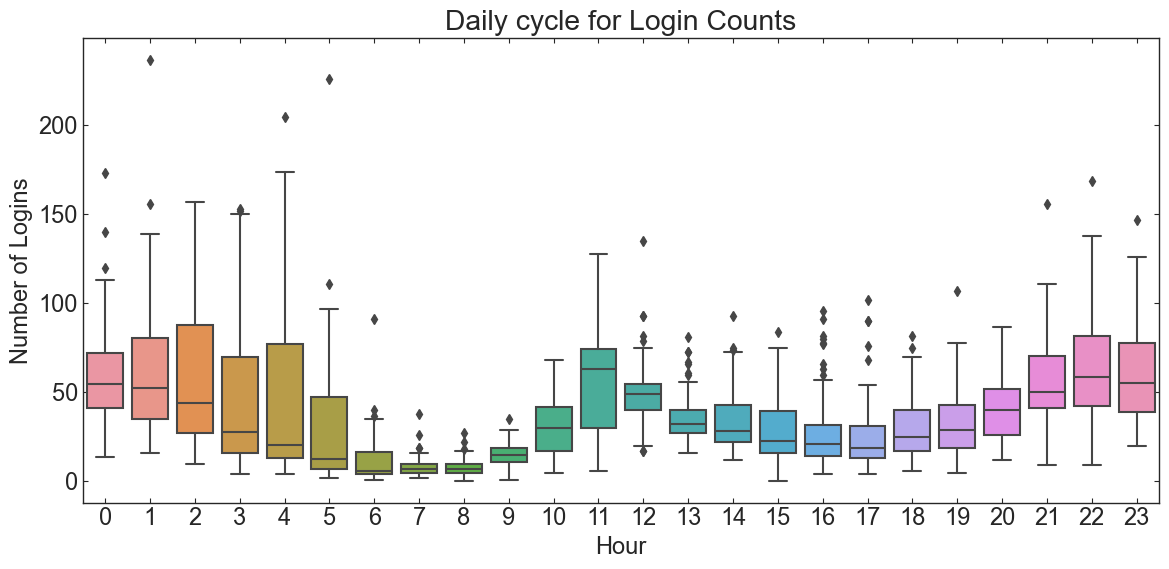

In [23]:
fig, ax = plt.subplots(figsize=(12,6))

sns.boxplot(x='Hour', y='Counts', data=df_logH, ax=ax)

ax.set(title='Daily cycle for Login Counts', ylabel='Number of Logins')

fig.tight_layout()
fig.savefig(os.path.join(figdir,'box_hour.png'));

> There are significant variation between 2am and 4am, and the smallest variation in the morning with the smallest logins.